<a href="https://colab.research.google.com/github/Ankit-tiwary-26/Cardio-Vascular-Disease/blob/main/CVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/mit-bih-arrhythmia-database-1.0.0.zip'  # change to your actual file name
extract_path = '/content/mitbih_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Unzipped!")


✅ Unzipped!


In [ ]:
!pip install wfdb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 73.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


In [ ]:
import wfdb
import os
import matplotlib.pyplot as plt


In [ ]:
data_path = '/content/mitbih_data'  # or wherever you extracted


In [ ]:
import os

# Main extracted path
main_path = '/content/mitbih_data'

# List all subfolders
subfolders = [os.path.join(main_path, f) for f in os.listdir(main_path) if os.path.isdir(os.path.join(main_path, f))]
print("Subfolders found:", subfolders)


Subfolders found: ['/content/mitbih_data/mit-bih-arrhythmia-database-1.0.0']


In [ ]:
# Assuming the ECG files are in the first subfolder
ecg_data_path =  '/content/mitbih_data/mit-bih-arrhythmia-database-1.0.0' # You can manually set this too

# Check some .dat files
ecg_files = [f for f in os.listdir(ecg_data_path) if f.endswith('.dat')]
print("ECG records found:", ecg_files[:5])


ECG records found: ['234.dat', '114.dat', '119.dat', '220.dat', '213.dat']


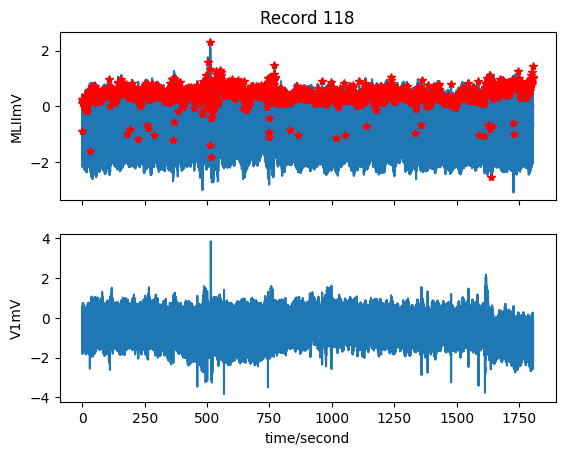

In [ ]:
import wfdb

record_id = '118'  # Example record
record_path = os.path.join(ecg_data_path, record_id)

record = wfdb.rdrecord(record_path)
annotation = wfdb.rdann(record_path, 'atr')

wfdb.plot_wfdb(record=record, annotation=annotation, title=f"Record {record_id}")



In [ ]:
import os
import wfdb
import numpy as np
from tqdm import tqdm

# Path to folder containing all MIT-BIH records
ecg_data_path = '/content/mitbih_data/mit-bih-arrhythmia-database-1.0.0'

# Multiclass label mapping (customize as needed)
label_map = {
    'N': 0,  # Normal beat
    'V': 1,  # Premature Ventricular Contraction
    'L': 2,  # Left bundle branch block
    'R': 3,  # Right bundle branch block
    'A': 4,  # Atrial premature beat
    'F': 5   # Fusion of ventricular and normal beat
}

# Extraction parameters
fs = 360  # Sampling frequency
window_sec = 3
window_size = fs * window_sec

X = []
y = []

# List all .dat files (one per record)
record_files = [f[:-4] for f in os.listdir(ecg_data_path) if f.endswith('.dat')]

for record_id in tqdm(record_files, desc="Processing records"):
    try:
        record_path = os.path.join(ecg_data_path, record_id)
        record = wfdb.rdrecord(record_path)
        annotation = wfdb.rdann(record_path, 'atr')

        for i, sample in enumerate(annotation.sample):
            symbol = annotation.symbol[i]
            if symbol not in label_map:
                continue  # skip unknown labels

            label = label_map[symbol]

            start = sample - window_size // 2
            end = sample + window_size // 2

            if start < 0 or end > len(record.p_signal):
                continue  # skip invalid windows

            segment = record.p_signal[start:end, 0]  # Use lead I
            X.append(segment)
            y.append(label)
    except Exception as e:
        print(f"Error in record {record_id}: {e}")
        continue


Processing records: 100%|██████████| 48/48 [00:03<00:00, 13.48it/s]


In [ ]:
from tensorflow.keras.utils import to_categorical

X = np.array(X)
X = X.reshape((X.shape[0], X.shape[1], 1))  # (samples, timesteps, 1)

y = np.array(y)
y = to_categorical(y)  # Convert to one-hot encoded labels

print("✅ Final Data Shapes:")
print("X:", X.shape)
print("y:", y.shape)


✅ Final Data Shapes:
X: (100701, 1080, 1)
y: (100701, 6)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

num_classes = y.shape[1]  # Automatically detects 6 classes (N, V, L, R, A, F)

model = Sequential([
    Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(X.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Multiclass output
])

model.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',  # Multiclass loss
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1076, 32)       │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 538, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 534, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 267, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 17088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,187,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,198,662 (8.39 MB)

 Trainable params: 2,198,662 (8.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Then use the CNN model I shared earlier for multiclass classification


In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
2518/2518 ━━━━━━━━━━━━━━━━━━━━ 243s 96ms/step - accuracy: 0.9100 - loss: 0.2966 - val_accuracy: 0.9627 - val_loss: 0.1345
Epoch 2/10
2518/2518 ━━━━━━━━━━━━━━━━━━━━ 236s 94ms/step - accuracy: 0.9597 - loss: 0.1461 - val_accuracy: 0.9761 - val_loss: 0.0857
Epoch 3/10
2518/2518 ━━━━━━━━━━━━━━━━━━━━ 267s 96ms/step - accuracy: 0.9716 - loss: 0.1040 - val_accuracy: 0.9814 - val_loss: 0.0692
Epoch 4/10
2518/2518 ━━━━━━━━━━━━━━━━━━━━ 265s 97ms/step - accuracy: 0.9788 - loss: 0.0803 - val_accuracy: 0.9831 - val_loss: 0.0582
Epoch 5/10
2518/2518 ━━━━━━━━━━━━━━━━━━━━ 255s 94ms/step - accuracy: 0.9818 - loss: 0.0650 - val_accuracy: 0.9856 - val_loss: 0.0505
Epoch 6/10
2518/2518 ━━━━━━━━━━━━━━━━━━━━ 246s 98ms/step - accuracy: 0.9843 - loss: 0.0575 - val_accuracy: 0.9871 - val_loss: 0.0473
Epoch 7/10
2518/2518 ━━━━━━━━━━━━━━━━━━━━ 229s 91ms/step - accuracy: 0.9864 - loss: 0.0488 - val_accuracy: 0.9865 - val_loss: 0.0484
Epoch 8/10
2518/2518 ━━━━━━━━━━━━━━━━━━━━ 225s 89ms/step - accuracy: 

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc * 100:.2f}%")


630/630 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.9863 - loss: 0.0500
Test Accuracy: 98.78%


In [ ]:
import numpy as np

prediction = model.predict(X_test[0:1])
predicted_class = np.argmax(prediction, axis=1)[0]
print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Predicted class: 2


In [ ]:
# After training
pred = model.predict(X_test[0:1])
print("Softmax prediction:", pred)

predicted_class = np.argmax(pred, axis=1)[0]
print("Predicted beat class:", predicted_class)

# Decode label
label_map = {'N': 0, 'V': 1, 'L': 2, 'R': 3, 'A': 4, 'F': 5}
class_map = {v: k for k, v in label_map.items()}
print("Beat type:", class_map[predicted_class])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Softmax prediction: [[1.0870564e-06 2.6207743e-04 9.9973446e-01 2.0295663e-06 4.8199160e-09
  3.3539544e-07]]
Predicted beat class: 2
Beat type: L


In [ ]:
label_map = {
    0: 'Normal',
    1: 'Premature Ventricular Contraction (PVC)',
    2: 'Left Bundle Branch Block (LBBB)',
    3: 'Right Bundle Branch Block (RBBB)',
    4: 'Atrial Premature Beat',
    5: 'Fusion Beat'
}


In [ ]:
import wfdb
import numpy as np

# Load any new ECG file (.dat, .hea, .atr must be in same folder)
record_path = '/content/mitbih_data/mit-bih-arrhythmia-database-1.0.0/118'  # Replace with your uploaded path
record = wfdb.rdrecord(record_path)
annotation = wfdb.rdann(record_path, 'atr')

# Pick a beat (e.g., the first one with a known label)
for i, symbol in enumerate(annotation.symbol):
    if symbol in ['N', 'V', 'L', 'R', 'A', 'F']:  # valid classes
        sample = annotation.sample[i]
        break

# Extract 3-sec segment around the beat
fs = record.fs
window_size = fs * 3
start = sample - window_size // 2
end = sample + window_size // 2

segment = record.p_signal[start:end, 0]


In [ ]:
# Preprocess for CNN
segment = segment.reshape(1, window_size, 1)  # (1, 1080, 1)


ValueError: cannot reshape array of size 0 into shape (1,1080,1)

In [ ]:
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('/content/ecg_model.h5')  # Update path if needed

# Predict
pred = model.predict(segment)
pred_class = np.argmax(pred, axis=1)[0]

# Get label
print("Prediction:", label_map[pred_class])


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/ecg_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)